# Introduction to JumpStart - Text to Image

***
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart). 

In this demo notebook, we demonstrate how to use the JumpStart API for Text-to-Image. Text-to-Image is the task of generating realistic images given any text input. Here, we show how to use state-of-the-art pre-trained Stable Diffusion models for generating image from text.

***

1. [Set Up](#1.-Set-Up)
2. [Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model)
    * [Select a model](#2.1.-Select-a-Model)
    * [Retrieve JumpStart Artifacts & Deploy an Endpoint](#2.2.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
    * [Query endpoint and parse response](#2.3.-Query-endpoint-and-parse-response)
    * [Supported Inference parameters](#2.4.-Supported-Inference-parameters)
    * [Compressed Image Output](#2.5.-Compressed-Image-Output)
    * [Clean up the endpoint](#2.6.-Clean-up-the-endpoint)

3. [Fine-tune the pre-trained model on a custom dataset](#3.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#3.1.-Retrieve-Training-Artifacts)
    * [Set Training parameters](#3.2.-Set-Training-parameters)
    * [Start Training](#3.3.-Start-Training)
    * [Deploy and run inference on the fine-tuned model](#3.4.-Deploy-and-run-inference-on-the-fine-tuned-model)


Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

### 1. Set Up

***
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker and ipywidgets

***

In [18]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../code_util')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!pip install sagemaker --upgrade --quiet
!pip install ipywidgets==7.0.0 --quiet

#### Permissions and environment variables

***
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. 

***

In [4]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

## 2. Run inference on the pre-trained model

***

Using JumpStart, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset.
***

### 2.1. Select a Model
***
You can continue with the default model, or can choose a different model from the dropdown generated upon running the next cell. A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).

***

In [5]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == txt2img"
txt2img_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=txt2img_models,
    value="model-txt2img-stabilityai-stable-diffusion-v2",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

A Jupyter Widget

In [73]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

In [75]:
print("model_id: ", model_id, "\nmodel_version: ", model_version)

model_id:  model-txt2img-stabilityai-stable-diffusion-v2-1-base 
model_version:  *


### 2.2. Retrieve JumpStart Artifacts & Deploy an Endpoint

***

Using JumpStart, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. We start by retrieving the `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [sagemaker.model.Model](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it. This may take a few minutes.

***

In [7]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model uri. This includes the pre-trained nvidia-ssd model and parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)



------------!

In [78]:
print("deploy_image_uri: \n", deploy_image_uri)
print("deploy_source_uri: \n", deploy_source_uri)
print("model_uri: \n", model_uri)

deploy_image_uri: 
 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
deploy_source_uri: 
 s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.1/sourcedir.tar.gz
model_uri: 
 s3://jumpstart-cache-prod-us-east-1/stabilityai-infer/infer-model-txt2img-stabilityai-stable-diffusion-v2.tar.gz


In [ ]:
%%time

# To increase the maximum response size from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

### 2.3. Query endpoint and parse response

***
Input to the endpoint is any string of text dumped in json and encoded in `utf-8` format. Output of the endpoint is a `json` with generated text.

***

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = json.dumps(text).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

***
Below, we put in some example input text. You can put in any text and the model predicts the image corresponding to that text.

***

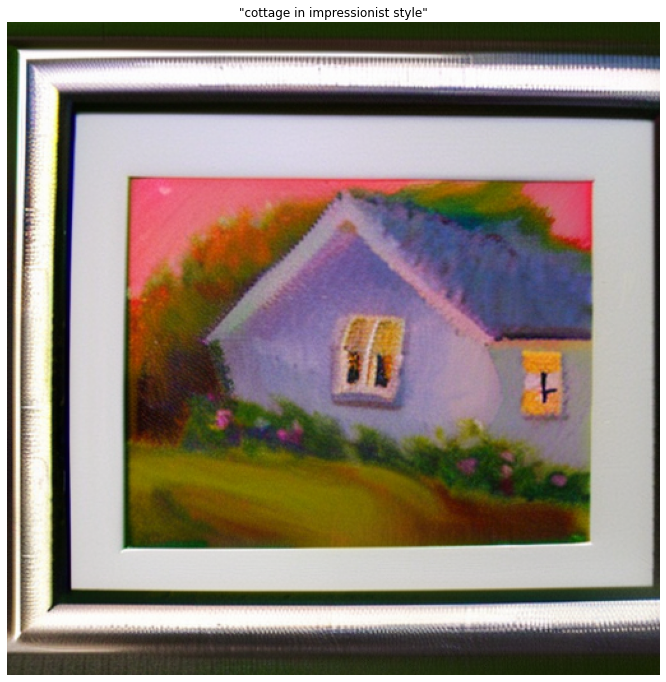

In [9]:
text = "cottage in impressionist style"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

### 2.4. Supported Inference parameters

***
This model also supports many advanced parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **width**: width of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **height**: height of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **num_inference_steps**: Number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: Higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **num_images_per_prompt**: number of images returned per prompt. If specified it must be a positive integer. 
* **seed**: Fix the randomized state for reproducibility. If specified, it must be an integer.

***

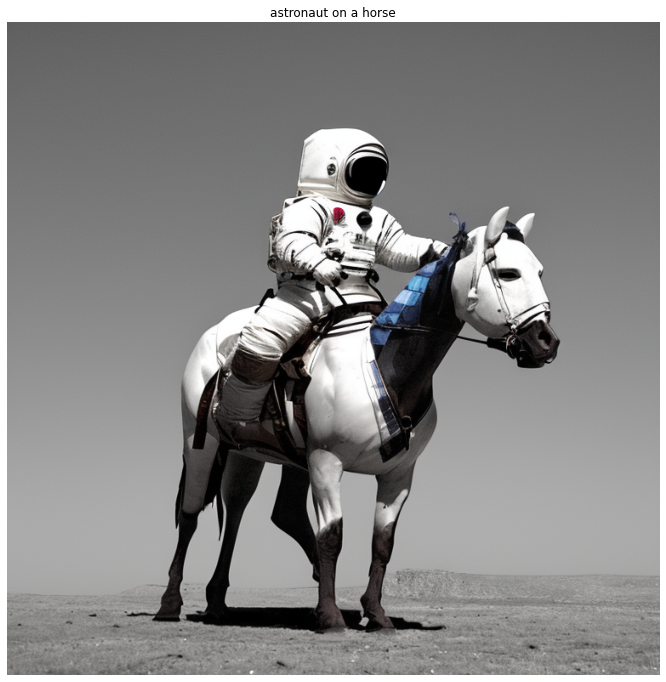

In [10]:
import json

# Training data for different models had different image sizes and it is often observed that the model performs best when the generated image
# has dimensions same as the training data dimension. For dimensions not matching the default dimensions, it may result in a black image.
# Stable Diffusion v1-4 was trained on 512x512 images and Stable Diffusion v2 was trained on 768x768 images.
payload = {
    "prompt": "astronaut on a horse",
    "width": 768,
    "height": 768,
    "num_images_per_prompt": 1,
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
}


def query_endpoint_with_json_payload(model_predictor, payload, content_type, accept):
    """Query the model predictor with json payload."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response_multiple_images(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


query_response = query_endpoint_with_json_payload(
    model_predictor, payload, "application/json", "application/json"
)
generated_images, prompt = parse_response_multiple_images(query_response)

for img in generated_images:
    display_img_and_prompt(img, prompt)

### 2.5. Compressed Image Output

---

Default response type above from an endpoint is a nested array with RGB values and if the generated image size is large, this may hit response size limit. To address this, we also support endpoint response where each image is returned as a JPEG image returned as bytes. To do this, please set `Accept = 'application/json;jpeg'`.


---

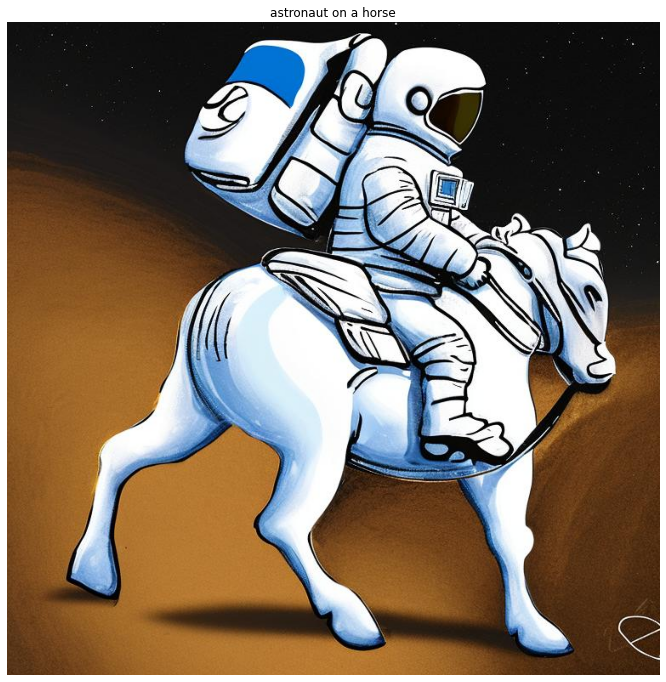

In [11]:
from PIL import Image
from io import BytesIO
import base64
import json

query_response = query_endpoint_with_json_payload(
    model_predictor, payload, "application/json", "application/json;jpeg"
)
generated_images, prompt = parse_response_multiple_images(query_response)

# generated_images are a list of jpeg images as bytes with b64 encoding.
# Next, we decode the images and convert to RGB format before displaying

for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
    display_img_and_prompt(generated_image_rgb, prompt)

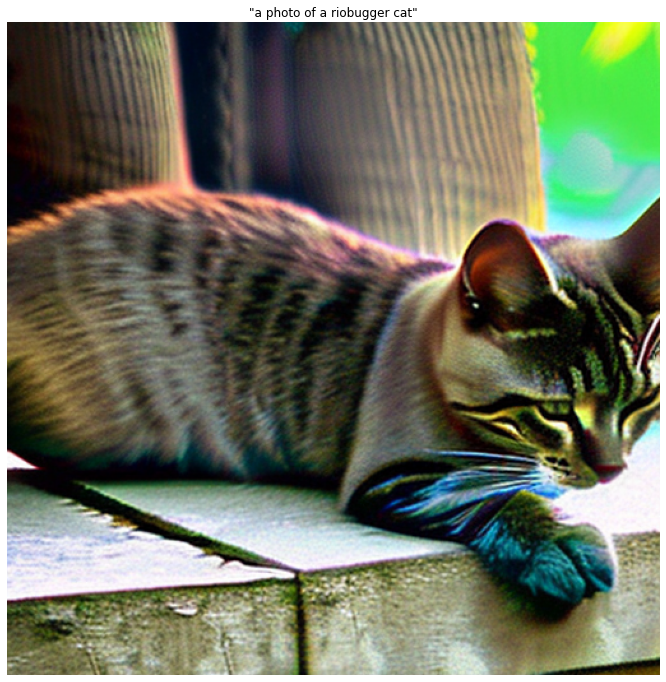

In [12]:
text = "a photo of a riobugger cat"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

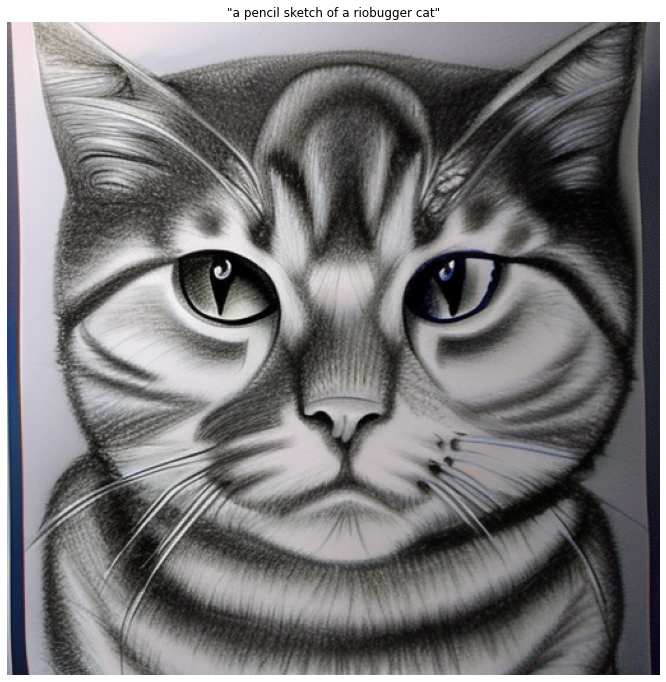

In [70]:
text = "a pencil sketch of a riobugger cat"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

### 2.6. Clean up the endpoint

In [13]:
# # Delete the SageMaker endpoint
# model_predictor.delete_model()
# model_predictor.delete_endpoint()

## 3. Fine-tune the pre-trained model on a custom dataset

---
Previously, we saw how to run inference on a pre-trained model. Next, we discuss how a model can be finetuned to a custom dataset with any number of classes.

The model can be fine-tuned to any dataset of images. It works very well even with as little as five training images.

The fine-tuning script is built on the script from [dreambooth](https://dreambooth.github.io/). The model returned by fine-tuning can be further deployed for inference. Below are the instructions for how the training data should be formatted.

- **Input:** A directory containing the instance images, `dataset_info.json` and (optional) directory `class_data_dir`.
  - Images may be of `.png` or `.jpg` or `.jpeg` format.
  - `dataset_info.json` file must be of the format {'instance_prompt':<<instance_prompt>>,'class_prompt':<<class_prompt>>}.
  - If with_prior_preservation = False, you may choose to ignore 'class_prompt'.
  - `class_data_dir` directory must have class images. If with_prior_preservation = True and class_data_dir is not present or there are not enough images already present in class_data_dir, additional images will be sampled with class_prompt.
- **Output:** A trained model that can be deployed for inference.

The s3 path should look like `s3://bucket_name/input_directory/`. Note the trailing `/` is required.

Here is an example format of the training data.

    input_directory
        |---instance_image_1.png
        |---instance_image_2.png
        |---instance_image_3.png
        |---instance_image_4.png
        |---instance_image_5.png
        |---dataset_info.json
        |---class_data_dir
            |---class_image_1.png
            |---class_image_2.png
            |---class_image_3.png
            |---class_image_4.png

**Prior preservation, instance prompt and class prompt:** Prior preservation is a technique that uses additional images of the same class that we are trying to train on.  For instance, if the training data consists of images of a particular dog, with prior preservation, we incorporate class images of generic dogs. It tries to avoid overfitting by showing images of different dogs while training for a particular dog. Tag indicating the specific dog present in instance prompt is missing in the class prompt. For instance, instance prompt may be "a photo of a riobugger cat" and class prompt may be "a photo of a cat". You can enable prior preservation by setting the hyper-parameter with_prior_preservation = True.



We provide a default dataset of cat images. It consists of eight images (instance images corresponding to instance prompt) of a single cat with no class images. It can be downloaded from [here](https://github.com/marshmellow77/dreambooth-sm/tree/main/training-images). If using the default dataset, try the prompt "a photo of a riobugger cat" while doing inference in the demo notebook.


License: [MIT](https://github.com/marshmellow77/dreambooth-sm/blob/main/LICENSE).

### 3.1. Retrieve Training Artifacts

---
Here, we retrieve the training docker container, the training algorithm source, and the pre-trained base model. Note that model_version="*" fetches the latest model.

---

In [54]:
from sagemaker import image_uris, model_uris, script_uris

# Currently, not all the stable diffusion models in jumpstart support finetuning. Thus, we manually select a model
# which supports finetuning.
train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "*",
    "training",
)

# Tested with ml.g4dn.2xlarge (16GB GPU memory) and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training.
# training_instance_type = "ml.g4dn.2xlarge"
# training_instance_type = "ml.g5.2xlarge"
training_instance_type = "ml.g5.4xlarge"
# training_instance_type = "ml.p3.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [84]:
print("train_image_uri: \n", train_image_uri)
print("train_source_uri: \n", train_source_uri)
print("train_model_uri: \n", train_model_uri)

train_image_uri: 
 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04
train_source_uri: 
 s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/transfer_learning/txt2img/v1.0.0/sourcedir.tar.gz
train_model_uri: 
 s3://jumpstart-cache-prod-us-east-1/stabilityai-training/train-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz


### 3.2. Set Training parameters

---
Now that we are done with all the set up that is needed, we are ready to train our stable diffusion model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job.

There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. We defined the training instance type above to fetch the correct train_image_uri.

The second set of parameters are algorithm specific training hyper-parameters.

---

In [55]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/cats_sd_finetuning/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-sd-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

---
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.

---

In [56]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["max_steps"] = "400"
print(hyperparameters)

{'epochs': '20', 'max_steps': '400', 'batch_size': '1', 'with_prior_preservation': 'False', 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'seed': '0'}


---

If setting `with_prior_preservation=True`, please use ml.g5.2xlarge instance type as more memory is required to generate class images. Currently, training on ml.g4dn.2xlarge instance type run into CUDA out of memory issue when setting `with_prior_preservation=True`.

---

## show training images

In [57]:
training_dataset_s3_path

's3://jumpstart-cache-prod-us-east-1/training-datasets/cats_sd_finetuning/'

In [58]:
! aws s3 ls {training_dataset_s3_path}

2023-01-30 14:25:03         90 dataset_info.json
2023-01-30 14:25:03      73182 riobugger1.jpeg
2023-01-30 14:25:04      33132 riobugger2.jpeg
2023-01-30 14:25:04      33626 riobugger3.jpeg
2023-01-30 14:25:05      37007 riobugger4.jpeg
2023-01-30 14:25:05      32985 riobugger5.jpeg
2023-01-30 14:25:05      56469 riobugger6.jpeg
2023-01-30 14:25:05      41459 riobugger7.jpeg
2023-01-30 14:25:06      41758 riobugger8.jpeg


In [59]:
download_loc = 'data/cat'

In [60]:
! aws s3 sync {training_dataset_s3_path} {download_loc}

In [61]:
import cv2
import glob
from matplotlib import pyplot as plt

dir_path = f'{download_loc}/*.jpeg'
download_list = sorted(glob.glob(dir_path))
print("download_list: \n", download_list)
# print("res: ", sorted(res))
im_list = []

for i, path in enumerate(res):
    im_list.append(cv2.imread(path))


download_list: 
 ['data/cat/riobugger1.jpeg', 'data/cat/riobugger2.jpeg', 'data/cat/riobugger3.jpeg', 'data/cat/riobugger4.jpeg', 'data/cat/riobugger5.jpeg', 'data/cat/riobugger6.jpeg', 'data/cat/riobugger7.jpeg', 'data/cat/riobugger8.jpeg']


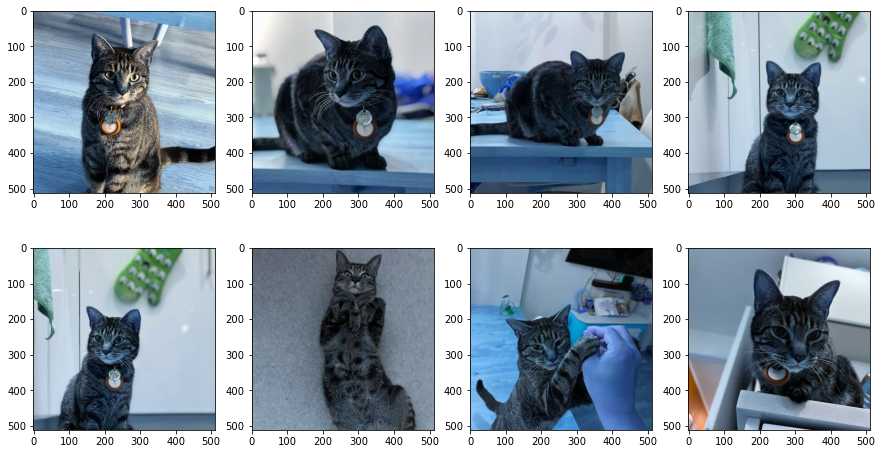

In [71]:
import math
from common_util import show_multiple_images

img_num = 8
col = 4
row = math.ceil(img_num / col)
show_multiple_images(img_num = img_num, row= row, col=col, im_list=im_list, fig_row=15, fig_col=8)

### 3.3. Start Training
---
We start by creating the estimator object with all the required assets and then launch the training job.  It takes less than 10 mins on the default dataset.

---

In [63]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)

# Launch a SageMaker Training job by passing s3 path of the training data
sd_estimator.fit({"training": training_dataset_s3_path}, wait=False)

INFO:sagemaker:Creating training-job with name: jumpstart-example-model-txt2img-stabili-2023-02-12-11-39-19-322


In [64]:
%%time 
sd_estimator.logs()

2023-02-12 11:39:19 Starting - Starting the training job...
2023-02-12 11:39:35 Starting - Preparing the instances for training......
2023-02-12 11:40:41 Downloading - Downloading input data...............
2023-02-12 11:43:07 Training - Downloading the training image......
2023-02-12 11:44:12 Training - Training image download completed. Training in progress.......bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-12 11:45:09,370 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-12 11:45:09,391 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-12 11:45:09,393 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-12 11:45:10,276 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Processing ./lib/accelera

### Error on ml.p3.2xlarge
UnexpectedStatusException: Error for Training job jumpstart-example-model-txt2img-stabili-2023-02-12-08-00-56-841: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
ExitCode 1
ErrorMessage "NameError: name 'cuda_setup' is not defined"
Command "/opt/conda/bin/python3.8 transfer_learning.py --adam_beta1 0.9 --adam_beta2 0.999 --adam_epsilon 1e-08 --adam_weight_decay 0.01 --batch_size 1 --center_crop False --epochs 20 --gradient_accumulation_steps 1 --learning_rate 2e-06 --lr_scheduler constant --max_grad_norm 1.0 --max_steps 400 --num_class_images 100 --prior_loss_weight 1.0 --seed 0 --with_prior_preservation False", exit code: 1

### 3.4. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We follow the same steps as in [2. Run inference on the pre-trained model](#2.-Run-inference-on-the-pre-trained-model). We start by retrieving the jumpstart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `od_estimator` that we fine-tuned.

---

In [65]:
inference_instance_type = "ml.g4dn.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-FT-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = sd_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-02-12-12-01-39-742
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-FT-model-txt2img-stab-2023-02-12-12-01-39-742
INFO:sagemaker:Creating endpoint with name jumpstart-example-FT-model-txt2img-stab-2023-02-12-12-01-39-742


----------!

Next, we query the finetuned model, parse the response and display the generated image. Functions for these are implemented in sections [2.3. Query endpoint and parse response](#2.3.-Query-endpoint-and-parse-response). Please execute those cells.

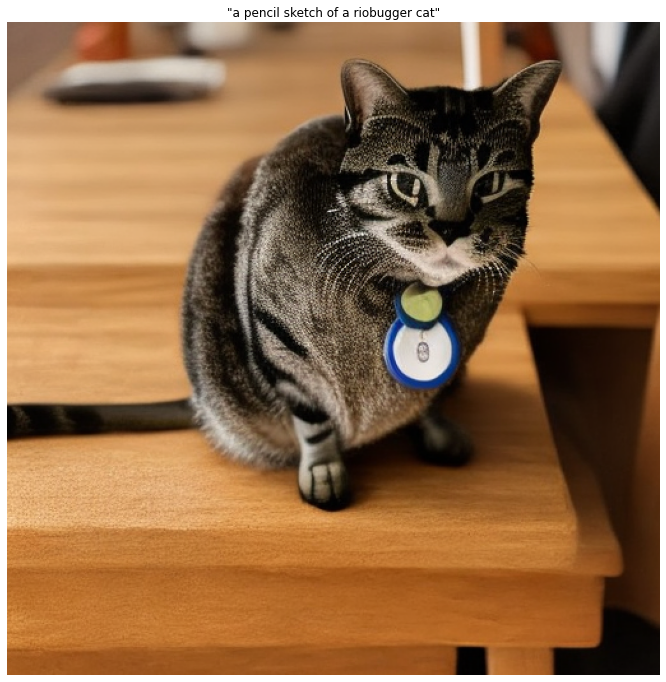

In [68]:
text = "a pencil sketch of a riobugger cat"
query_response = query(finetuned_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

All the parameters mentioned in [2.4. Supported Inference parameters](#2.4.-Supported-Inference-parameters) are supported with finetuned model as well. You may also receive compressed image output as in [2.5. Compressed Image Output](#2.5.-Compressed-Image-Output) by changing `accept`.

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [ ]:
# Delete the SageMaker endpoint
# finetuned_predictor.delete_model()
# finetuned_predictor.delete_endpoint()